# Linear Regression with Variational Inference and Markov Chain Monte Carlo Sampling

<a href="https://maltetoelle.github.io/linear/regression/2020/10/27/try.html">Here</a> you can fing more in depth information about the topic of linear regression in general. You might want to check it out, if you are unfamiliar with it. Here we will only review the most basic intuitions. In this post we will revisit two methods for approximating the intractable posterior in Bayesian inference, namely variational inference (VI) and Markov chain Monte Carlo (MCMC) sampling. While the latter is able to approximate the posterior exactly, it takes longer to converge. This can be eliminated with variational inference at the cost of no exact approximation. But more to come.

Given a dataset $\mathcal{D}=\{x_i,y_i\}$ with $N$ observations and a model with parameters $\boldsymbol{\theta}$ we want to find the best estimate for the true value for $y$:

$$\hat{y} = \theta_0 x^0 + \theta_1 x + \theta_2 x^2 + ... \theta_M x^M = \boldsymbol{\theta}^T\boldsymbol{\Phi} ~,$$

where we defined $\boldsymbol{\Phi} = (\Phi_0(x_i),...,\Phi_M(x_i))$ to be a $N\times M$ matrix with $\Phi_p(x_i)=x_i^p$ of and $\hat{y}$ denotes the output of our model. Since all real world data is corrupted or distorted by noise coming from different sources (e.g. limitations in measurement tools), the true observations are pertubed with noise $\epsilon$, which is assumed to be a Gaussian with zero mean and variance $\sigma^2$:

$$y_i=\boldsymbol{\theta}^T\mathbf{x}_i + \epsilon_i \quad \textrm{with} \quad \epsilon_i \sim \mathcal{N}(0,\sigma^2) ~.$$

Thus, we can model each point with a Gaussian distribution

$$p(y_i|\Phi_i,\boldsymbol{\theta},\sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp \left\{-\frac{1}{2\sigma^2}(y_i - \boldsymbol{\theta}^T\Phi_i)^2 \right\} ~.$$

Assuming i.i.d. data points the probability of all points called likelihood factorizes:

$$p(\mathbf{y}|\boldsymbol{\Phi},\boldsymbol{\theta}) = \prod_i p(y_i|\Phi_i,\boldsymbol{\theta}) = \sum_i \log p(y_i|\Phi_i,\boldsymbol{\theta}) ~,$$

where $\sigma^2$ is absorbed into $\boldsymbol{\theta}$ making it a variable of our model. Derivating for $\boldsymbol{\theta}$ and setting the derivative to 0 yields the maximum likelihood estimate (MLE). In contrast to MLE variational inference (VI) and Markov chain Monte Carlo (MCMC) sampling provide measures for certainty in the proposed parameters by making use of Bayes' theroem:

$$p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})= \frac{p(\mathbf{y}|\boldsymbol{\Phi},\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathbf{y}|\boldsymbol{\Phi})}~, \\\textrm{which speaks}\quad \textrm{posterior} = \frac{\textrm{likelihood } \times \textrm{ prior}}{\textrm{evidence}} ~.$$

While the likelihood is the one from above, we introduce three new terms here: the posterior, prior, and evidence. The likelihood is multiplied by a prior, a distribution over $\boldsymbol{\theta}$, that quantifies our believe in the model parameters prior to any training. We can also express zero prior knowledge by using a uniform distribution or a fairly wide Gaussian, when we assume our parameters to have Gaussian distributions. When we have computed the product of likelihood and prior, the evidence normalizes that product to obtain a valid probability distribution. The evidence can be seen as probability for seeing that particular data. After we have performed these computations, we obtain the posterior: the probability distribution of the parameters after seeing data.
For a new data point $(x_∗, y_*)$ the prediction of the model is obtained by considering
the predictions made using all possible parameter setting, weighted by their posterior
probability:

$$p(y_*|\Phi(x_*),\boldsymbol{\Phi},\mathbf{y}) = \int p(y_*|\Phi(x_*),\boldsymbol{\theta})p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})d\boldsymbol{\theta} ~.$$

Problematically this integral becomes intractable for even small models that are non-linear, so that other techniques such as VI and MCMC sampling must be employed. Here we compare both methods for the linear regression case starting with the exact approximation with Markov chain Monte Carlo sampling.

In [1]:
import matplotlib
%matplotlib inline

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Callable

import seaborn as sns
sns.set()

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

### Generating example data
$y = \theta_0 + \theta_1 x + \epsilon = -1 + x + \epsilon \quad \textrm{with} \quad \epsilon \sim \mathcal{N}(0,0.15)$ .

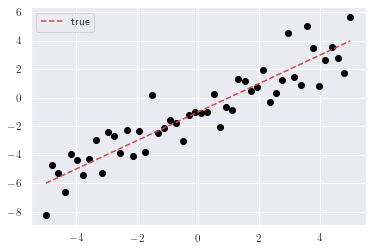

In [2]:
def model(x, weights):
    X = np.array([x**k for k in range(len(weights))]).transpose()
    return (X @ weights[:,np.newaxis]).flatten()

no_samples = 50

x = np.linspace(-5, 5, no_samples)

weights = np.array([-1, 1])
std_noise = 1.2

y_true = model(x, weights)
y_noisy = y_true + np.random.normal(0, std_noise, len(y_true))

plt.plot(x, y_true, color='r', linestyle='--', label='true')
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.show()

### Markov chain Monte Carlo Sampling

One popular technique for approximating the intractable posterior is MCMC sampling, contrary to other methods it makes no assumption concerning the form of the distribution, such as wether it can be approximated by a multivariate Gaussian. They only assume the posterior $p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})$ can be calculated up to normalization constant $Z$ meaning $p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})=\tilde{p}(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})/Z$, where $Z$ denotes the evidence in our case (<a href="http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf">Bishop 2006</a>).

In general, sampling methods try to find the expectation of some function $\mathbf{f}_{\boldsymbol{\theta}}$ w.r.t. the posterior distribution for the model parameter:

$$\mathbb{E}(\mathbf{f}) = \int \mathbf{f}_{\boldsymbol{\theta}}(\mathbf{x}_*)p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})d\boldsymbol{\theta} ~.$$

The integral in above equation is approximated using Monte Carlo sampling:

$$\mathbb{E}(\mathbf{f}) = \frac{1}{M} \sum_{i=1}^M \mathbf{f}_{\boldsymbol{\theta}_i}(\mathbf{x}_i) \quad \textrm{where} \quad \boldsymbol{\theta}_i \sim p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y}) ~.$$

Similar, the variance can be denoted by

$$\textrm{Var}[\mathbf{f}] = \frac{1}{M} \mathbb{E}[(\mathbf{f}-\mathbb{E}[\mathbf{f}])^2] ~,$$

if the generated samples from the posterior $\boldsymbol{\theta}_i$ are independent. For complicated posterior distributions this is mostly impossible, but it still gives an unbiased estimate, if the number of generated samples is high enough (<a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf">Neal 1996</a>).

To generate a set of dependent weights $\boldsymbol{\theta}_i$ a Markov chain can be utilized that has
the posterior $p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})$ as its equilibrium distribution. Markov Chains are a sequence of events, where the probability of one event depends only on the state of the previous one. So, one
samples from a proposal distribution $q(\boldsymbol{\theta}|\boldsymbol{\theta}_i)$ and maintains a record of the current state $\boldsymbol{\theta}_i$. A Markov chain is defined by giving an initial distribution for the
first state of the chain $\boldsymbol{\theta}_1$ and a transition distribution for a new state $\boldsymbol{\theta}_{i+1}$ following from the current state $\boldsymbol{\theta}_i$. A stationary distribution q is established if the distribution
given by state $\boldsymbol{\theta}_{i+1}$ is the same as with state $\boldsymbol{\theta}_i$. If the drawn samples are dependent then early drawn samples need to be discarded, since they usually are not representatives
of the equilibrium distribution referred to as burn in phase. If the samples are dependent
the chain also needs much longer to reach its equilibrium distribution (<a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf">Neal 1996</a>).

A popular algorithm for MCMC sampling is Metropolis-Hastings (<a href="https://bayes.wustl.edu/Manual/EquationOfState.pdf">Metropolis et al. 1953</a>, <a href="https://academic.oup.com/biomet/article-abstract/57/1/97/284580?redirectedFrom=fulltext">Hastings 1970</a>). The acceptance probability Ai at time step i is given by

$$A_i(\boldsymbol{\theta}_*,\boldsymbol{\theta}_i) = \textrm{min} \left( 1, \frac{q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_*)\tilde{p}(\boldsymbol{\theta}_*)}{q(\boldsymbol{\theta}_*|\boldsymbol{\theta}_i)\tilde{p}(\boldsymbol{\theta}_i)}  \right) ~,$$

where $\boldsymbol{\theta}_i$ denotes the current state and $\boldsymbol{\theta}_*$ the drawn proposal state, $\tilde{p}(\boldsymbol{\theta})$ is the prior of the model parameters. The normalization constants cancel out each other. After the acceptance probability is calculated, a random number $r$ is drawn from a Uniform distribution $r \sim \mathcal{U}(0,1)$. If $A_i > r$ the proposal state is accepted. 

In [3]:
class MCMC:
    def __init__(self, start_params: np.ndarray, model: Callable, num_iter: int = 10000, burnin_iter: int = 5000):
        self.num_iter = num_iter
        self.burnin_iter = burnin_iter
        self.start_params = start_params
        self.model = model
    
    def proposal_fct(self, params: np.ndarray, scale_weights: float = 0.5, scale_std_noise: float = 0.5) -> np.ndarray:
        if isinstance(scale_weights, (float, int)):
            scale_weights = [scale_weights for _ in range(len(params)-1)]
        return np.append(np.random.normal(loc=params[:-1], scale=scale_weights), np.random.normal(loc=params[-1], scale=scale_std_noise))
    
    def metropolis_hastings(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        self.chain = np.zeros((self.num_iter, len(self.start_params)))
        self.chain[0] = self.start_params
        
        log_post = lambda p: self.log_posterior(x, y, p, self.model)

        for i in tqdm(range(self.num_iter-1)):
            proposal = self.proposal_fct(self.chain[i])
            posterior_prob = np.exp(log_post(proposal) - log_post(self.chain[i]))
            if np.random.uniform(0, 1) < posterior_prob:
                self.chain[i+1] = proposal
            else:
                self.chain[i+1] = self.chain[i]

        self.posterior_params = self.chain[self.burnin_iter:].mean(axis=0)
        
        return self.posterior_params
    
    def posterior_pred(self, x: np.ndarray) -> np.ndarray:
        y_pred = np.array([self.model(x, c[:-1]) for c in self.chain[self.burnin_iter:]])
        return y_pred.mean(axis=0).flatten(), y_pred.std(axis=0).flatten()
    
    @staticmethod
    def log_prior(params: np.ndarray, prior_scale_weights: float = 1., prior_scale_noise: float = 5.) -> float:
        if isinstance(prior_scale_weights, (float, int)):
            prior_scale_weights = [prior_scale_weights for _ in range(len(params)-1)]
        log_prior_weights = np.array([stats.norm.logpdf(w, loc=0, scale=psw) for w, psw in zip(params[:-1], prior_scale_weights)])
        log_prior_noise = stats.uniform.logpdf(params[-1], loc=0, scale=prior_scale_noise)
        return log_prior_weights.sum() + log_prior_noise
    
    @staticmethod
    def log_likelihood(x: np.ndarray, y: np.ndarray, params: np.ndarray, model: Callable) -> float:
        y_pred = model(x, params[:-1])
        log_likelihoods = stats.norm.logpdf(y, loc=y_pred, scale=params[-1])
        return np.sum(log_likelihoods)
    
    def log_posterior(self, x: np.ndarray, y: np.ndarray, params: np.ndarray, model: Callable) -> float:
        return self.log_likelihood(x, y, params, model) + self.log_prior(params)

## Variational Inference

Coming from the exact but time consuming approximation technique of MCMC we will now go on and revisit an approximate inference technique called Variational inference (VI). We will mainly follow the derivations of <a href="http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf">Bishop (2006)</a>. VI has its origin in the 18th century by the work of Euler, Lagrange and others on the calculus of variations, which works on functionals. In contrast to a function that takes a value as input and returns another value, a functional takes a function as input and returns a value. An example for this is the entropy:

$$\textrm{H}[p]=-\int p(x) \log p(x) \, \mathrm{d}x ~,$$

which takes as input a probability distribution and returns a value. The derivative of a function describes how much the output value changes as we make infinitesimal changes to the input value. Consequently, the derivative of a functional describes how much the output value changes, if we make infinitesimal changes to the function. Our goal is to find the function that minimizes the functional. Since many functions (such as neural networks) are very complex because of their high number of parameters, they lend themselves to approximation by restricting the range of functions over which the optimization is performed.

In the fully Bayesian treatment of VI all parameters are given prior distributions, where $\boldsymbol{\theta}$ are our parameters (and all latent variables) and $\mathbf{X}$ are our observed variables. Our probabilistic model is given by the joint distribution $p(\mathbf{X},\boldsymbol{\theta})$. Our goal is to find approximations for the posterior the evidence from Bayes theorem. We do so by approximating our intractable posterior distribution $p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y})$ with a simpler distribution $q(\boldsymbol{\theta})$ from a family of distributions $\mathcal{Q}$ e.g. the multivariate Gaussian. The optimization objective is then given by the Kullback-Leibler (KL) divergence between our approximate and the true posterior:

\begin{equation*}
F(q):=\mathrm{KL}(q(\boldsymbol{\theta})||p(\boldsymbol{\theta}|\mathcal{D}))=\int q(\boldsymbol{\theta})\log \frac{q(\boldsymbol{\theta})}{p(\boldsymbol{\theta}|\mathcal{D})}\,\mathrm{d}\boldsymbol{\theta} \longrightarrow \underset{q(\boldsymbol{\theta}) \in \mathcal{Q}}{\min} ~.
\label{eq:vi_criterion}\tag{1}
\end{equation*}

Although the KL divergence is not a true distance metric because of its asymmetry, it can be seen as one in this case. The KL divergence is analysed in more depth in this <a href="">post</a>. For now it is enough to now that it is only zero if and only if both distributions are equal. For all other cases it is always greater than zero.

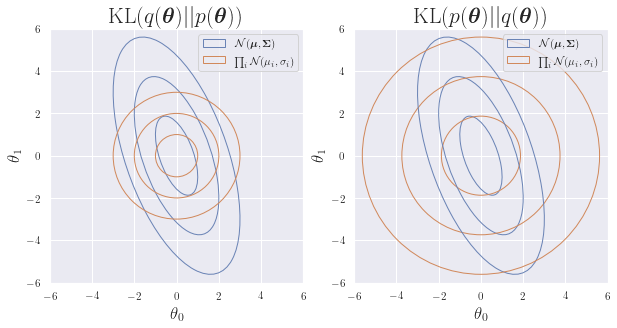

In [6]:
mu = [0, 0]
cov = np.array([[1, -1], [-1, 3.5]])
cov1 = np.eye(2) * cov[0,0]
cov2 = np.eye(2) * cov[1,1]

fig, axs = plt.subplots(1, 2, figsize=(10,5))

for ax, cov_vi in zip(axs, [cov1, cov2]):
    for n_std in np.arange(0, 4, 1):
        ell_true = confidence_ellipse(mu, cov, ax, n_std=n_std, edgecolor='#6A83B5')
        ell_vi = confidence_ellipse(mu, cov_vi, ax, n_std=n_std, edgecolor='#D1895C')

for ax, title in zip(axs, [r'$\mathrm{KL}(q(\bm{\theta})||p(\bm{\theta}))$', 
                           r'$\mathrm{KL}(p(\bm{\theta})||q(\bm{\theta}))$']):
    ax.set_ylim([-6, 6])
    ax.set_xlim([-6, 6])
    ax.set_xlabel(r'$\theta_0$', fontsize=17)
    ax.set_ylabel(r'$\theta_1$', fontsize=17)
    ax.set_title(title, fontsize=22)
    ax.set_aspect(1)
    ax.legend([ell_true, ell_vi], [r'$\mathcal{N}(\bm{\mu},\bm{\Sigma})$', 
                                   r'$\prod_i \mathcal{N}(\mu_i,\sigma_i)$'])

### Bayesian Linear Regression with Variational Inference

We perform Bayesian linear regression on the same model already used in the blog post about <a href="https://maltetoelle.github.io/linear/regression/2020/10/27/try.html">Bayesian linear regression</a> using Bayes theorem. Recall the likelihood for our observed target variables $\mathbf{y}$ and the prior distribution for our model parameters $\boldsymbol{\theta}$ are given by

$$
\begin{aligned}
p(\mathbf{y}|\boldsymbol{\theta}) &= \prod_{n=1}^{N} \mathcal{N}\left( y_n | \boldsymbol{\theta}^T \Phi_n, \beta^{-1} \right) ~, \\
p(\boldsymbol{\theta}|\alpha) &= \mathcal{N}\left( \mathbf{0},\alpha^{-1}\mathbf{I}_{M+1} \right) ~,
\end{aligned}
$$

with $\Phi_n=\Phi(x_n)=(x_n^0,x_n^1,...,x_n^{M})^T$ where $M$ denotes the degree of the fitted polynomial and $\mathbf{I}_{M+1}$ denotes the identity matrix of size $M+1$. We now introduce prior distributions over $\alpha$ and $\beta$. The conjugate prior for Gaussian distributions is the Wishart distribution or in the one dimensional case the Gamma distribution:

$$
\begin{aligned}
p(\alpha) &= \textrm{Gam}(\alpha|a_0,b_0) ~, \\
p(\beta) &= \textrm{Gam}(\beta|c_0,d_0) ~.
\end{aligned}
$$

The definition of the Gamma and log Gamma distribution can be found in the appendix at the end of the post. Thus, the joint distribution of all the variables is given by

$$
p(\mathbf{y},\boldsymbol{\theta},\alpha,\beta) = p(\mathbf{y}|\boldsymbol{\theta},\beta) p(\boldsymbol{\theta}|\alpha) p(\beta) p(\alpha) ~.
$$

By using the mean field approximation the approximation of the posterior $p(\boldsymbol{\theta},\alpha,\beta)$ is given by the factorization

$$
q(\boldsymbol{\theta},\alpha,\beta)=q(\boldsymbol{\theta})q(\alpha)q(\beta) ~.
$$

We can find the optimal variational parameters for each of the above distributions by making use of Eq. (4). For each factor, we take the log of the joint distribution over all variables and then average w.r.t. to those variables not in the factor.

#### Variational density for $\alpha$

The log of our optimal variational density $q^*(\alpha)$ is given by

$$
\begin{aligned}
\log q^*(\alpha) &= \log p(\alpha) + \mathbb{E}\left[ \log p(\boldsymbol{\theta}|\alpha) \right] + \mathcal{Z} \\
&= (a_0 - 1) \log a - b_0 \alpha + \frac{M}{2} \log \alpha - \frac{\alpha}{2} \mathbb{E} \left[ \boldsymbol{\theta}^T \boldsymbol{\theta} \right] + \mathcal{Z} ~.
\end{aligned}
$$

We notice the above as the parameters of a log Gamma distribution, so, we can perform coefficient comparison and find the optimal variational distribution for $\alpha$ to be

$$
q^*(\alpha) = \textrm{Gam}(\alpha|a_N,b_N) ~,
$$

where

$$
\begin{aligned}
a_N &= a_0 + \frac{M}{2} ~, \\
b_N &= b_0 + \frac{1}{2}\mathbb{E}\left[ \boldsymbol{\theta}^T\boldsymbol{\theta} \right] ~.
\end{aligned}
$$

#### Variational density for $\boldsymbol{\theta}$

Similarly, the log of our optimal variational density $q^*(\theta)$ is given by

$$
\begin{aligned}
\log q^*(\boldsymbol{\theta}) &= \mathbb{E}_{\beta}\left[ \log p(\mathbf{y}|\boldsymbol{\theta},\beta) \right] + \mathbb{E}_{\alpha}\left[ p(\boldsymbol{\theta}|\alpha) \right] + \mathcal{Z} \\
&\propto -\frac{\mathbb{E}_{\beta}}{2} \sum_{n=1}^{N}\left( y_n - \boldsymbol{\theta}^T\Phi_n \right)^2 - \frac{\mathbb{E}_{\alpha}}{2} \boldsymbol{\theta}^T\boldsymbol{\theta} + \mathcal{Z} \\
&\propto -\frac{\mathbb{E}_{\beta}}{2} \sum_{n=1}^{N} \left\{-2\boldsymbol{\theta}^T\Phi_n y_n + \left(\boldsymbol{\theta}^T\Phi_n\right)^2 \right\} - \frac{\mathbb{E}_{\alpha}}{2} \boldsymbol{\theta}^T\boldsymbol{\theta} + \mathcal{Z} \\
&= -\frac{1}{2} \boldsymbol{\theta}^T \left\{ \mathbb{E}_{\beta} \boldsymbol{\Phi}^T\boldsymbol{\Phi} + \mathbb{E}_{\alpha}\mathbf{I} \right\} \boldsymbol{\theta} + \mathbb{E}_{\beta}\boldsymbol{\theta}^T\boldsymbol{\Phi}^T\mathbf{y} + \mathcal{Z} ~.
\end{aligned}
$$

We recognize this as a log normal distribution and find our coefficients to be

$$
q^*(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta}|\mathbf{m}_N,\mathbf{S}_N) ~,
$$

where

$$
\begin{aligned}
\mathbf{m}_N &= \mathbb{E}_{\beta} \mathbf{S}_N \boldsymbol{\Phi}^T \mathbf{y} ~, \\
\mathbf{S}_N &= \left( \mathbb{E}_{\beta}\boldsymbol{\Phi}^T\boldsymbol{\Phi} + \mathbb{E}_{\alpha} \mathbf{I} \right)^{-1} ~.
\end{aligned}
$$

#### Variational Density for $\beta$

As for $\alpha$ and $\boldsymbol{\theta}$, the optimal variational density $q^*(\beta)$ is given by

$$
\begin{aligned}
\log q^*(\beta) &= \log p(\beta) + \mathbb{E}_{\boldsymbol{\theta}}\left[ \log p(\mathbf{y}|\boldsymbol{\theta},\beta) \right] + \mathcal{Z} \\
&\propto (c_0 - 1)\log \beta - d_0\beta + \frac{N}{2} \log \beta - \frac{\beta}{2} \mathbb{E} \left[ \sum_{n=1}^{N} \left( y_n - \boldsymbol{\theta}^T\Phi_n \right)^2 \right] + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta - d_0\beta - \frac{\beta}{2} \mathbb{E}\left[ \mathbf{y}^T\mathbf{y} -2\boldsymbol{\theta}\boldsymbol{\Phi} \mathbf{y} + \boldsymbol{\theta}^T\boldsymbol{\Phi}^T\boldsymbol{\Phi}\boldsymbol{\theta} \right] + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta -\beta \left\{ d_0 + \frac{1}{2}\mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\, \mathbb{E}\left[ \boldsymbol{\theta}^T\boldsymbol{\theta} \right] \right] - \mathbb{E}\left[ \boldsymbol{\theta}^T \right] \boldsymbol{\Phi}\mathbf{y} + \frac{1}{2}\mathbf{y}^T\mathbf{y} \right\} + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta -\beta \left\{ d_0 + \frac{1}{2}\mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\left( \mathbf{m}_N\mathbf{m}_N^T + \mathbf{S}_N \right) \right] - \mathbf{y}^T\boldsymbol{\Phi}\mathbf{m}_N + \frac{1}{2}\mathbf{y}^T\mathbf{y} \right\} + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta -\beta \left\{ d_0 + \frac{1}{2}\mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{S}_N \right] + \frac{1}{2}\mathbf{m}_N^T\boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{m}_N - \mathbf{y}^T\boldsymbol{\Phi}\mathbf{m}_N + \frac{1}{2}\mathbf{y}^T\mathbf{y} \right\} + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta -\frac{\beta}{2} \left\{ 2d_0 + \mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{S}_N \right] + \sum_{n=1}^{N}\left( y_n - \mathbf{m}_N^T\Phi_n \right)^2 \right\} + \mathcal{Z} ~.
\end{aligned}
$$

We again recognize this as the coefficients of a log Gamma distribution

$$
q^*(\beta) = \textrm{Gam}(\beta|c_N,d_N) ~,
$$

where

$$
\begin{aligned}
c_N &= \frac{N}{2} + c_0 ~, \\
d_N &= d_0 + \frac{1}{2} \left\{ \mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{S}_N \right] + \sum_{n=1}^{N} \left( y_n - \mathbf{m}_N^T\Phi_n \right)^2 \right\} ~.
\end{aligned}
$$

#### Estimating the Missing Moments

The missing moments of the Gamma distributions for $\alpha$ and $\beta$ can be easily estimated from the definition of the distribution.

$$
\begin{aligned}
\mathbb{E}[\alpha] &= \frac{a_N}{b_N} \\
&= \frac{a_0 + \frac{M}{2}}{b_0 + \frac{1}{2}\mathbb{E}\left[ \boldsymbol{\theta}^T\boldsymbol{\theta} \right]}\\
&= \frac{a_0 + \frac{M}{2}}{b_0 + \frac{1}{2}\mathbf{m}_N^T\mathbf{m}_N + \textrm{Tr}(\mathbf{S}_N)} \quad \textrm{with} \quad \mathbb{E}\left[ \boldsymbol{\theta}\boldsymbol{\theta}^T \right] = \mathbf{m}_N\mathbf{m}_N^T + \mathbf{S}_N ~, \\
\mathbb{E}[\beta] &= \frac{c_N}{d_N} \\
&= \frac{\frac{N}{2} + c_0}{d_0 + \frac{1}{2} \left\{ \mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{S}_N \right] + \sum_{n=1}^{N} \left( y_n - \mathbf{m}_N^T\Phi_n \right)^2 \right\}}
\end{aligned}
$$

VI for linear regression is performed by cyclically estimating the parameters $a_N$, $b_N$, $c_N$, $d_N$, $\mathbf{m}_N$, and $\mathbf{S}_N$ with the corresponding update formulas. Which can be done in a small number of lines in code compared to the long derivations above. But before we take a look at the code, we must examine the predictive distribution of the model.

#### Predictive Distribution

The predictive distribution for new data points $(\mathbf{x}_*,\mathbf{y}_*)$ can easily be evaluated using the Gaussian variational posterior for the parameters

$$
\begin{aligned}
p(\mathbf{y}_*|\mathbf{x}_*,\mathbf{y}) &= \int p(\mathbf{y}_*|\mathbf{x}_*,\boldsymbol{\theta})p(\boldsymbol{\theta}|\mathbf{y})\,d\boldsymbol{\theta} \\
&= \int p(\mathbf{y}_*|\mathbf{x}_*,\boldsymbol{\theta})q(\boldsymbol{\theta})\,d\boldsymbol{\theta} \\
&= \int\mathcal{N}\left( \mathbf{y}_*|\boldsymbol{\theta}^T\boldsymbol{\Phi}(\mathbf{x}_*), \mathbb{E}[\beta] \right) \mathcal{N}\left( \boldsymbol{\theta} | \mathbf{m}_N,\mathbf{S}_N \right)\,d\boldsymbol{\theta} \\
&= \mathcal{N}\left( \mathbf{m}_N^T\boldsymbol{\Phi}(\mathbf{x}_*),\sigma^2(\mathbf{x}_*) \right) \quad \textrm{with} \quad \sigma^2(\mathbf{x}_*) = \frac{1}{\mathbb{E}[\beta]} + \boldsymbol{\Phi}(\mathbf{x}_*)^T \mathbf{S}_N \boldsymbol{\Phi}(\mathbf{x}_*) ~.
\end{aligned}
$$

In the above we incorporate the noise inherent in the observations in our prediction. Contrary to that we will sample our weights from the estimated mean and covariance and treat the noise in the observation as not be a part of the model. Our prediction then becomes

$$
\begin{gathered}
\boldsymbol{\theta}_i \sim \mathcal{N}(\boldsymbol{\theta}|\mathbf{m}_N,\mathbf{S}_N) ~,\\
y_i = \boldsymbol{\theta}_i^T\boldsymbol{\Phi} ~.
\end{gathered}
$$

In [7]:
class VI:
    def __init__(self, num_iter: int = 100, start_alpha: float = 0.1, start_beta: float = 0.1,
                 a0: float = 0., b0: float = 0., c0: float = 0., d0: float = 0.):
        
        # initializing all with 0 corresponds to an infinitely wide prior
        self.a0 = a0
        self.b0 = b0
        self.c0 = c0
        self.d0 = d0

        self.alpha = start_alpha
        self.beta = start_beta

        self.num_iter = num_iter
    
    def training(self, x: np.ndarray, y: np.ndarray, pol_grad: int = 1) -> (np.ndarray):
        self.D = pol_grad + 1
        N = len(y)
        X = np.array([x**k for k in range(self.D)]).transpose()
        
        aN = self.a0 + self.D/2 
        cN = self.c0 + N/2
        
        for i in tqdm(range(self.num_iter)):
            self.SN = np.linalg.inv(self.beta * X.T @ X + self.alpha * np.eye(self.D))
            
            self.mN = self.beta * self.SN @ X.T @ y
            
            dN = self.d0 + 0.5 * ((y - X @ self.mN)**2).sum() + 0.5 * np.trace(X.T @ X @ self.SN)
            self.beta = cN/dN
            
            bN = self.b0 + 0.5 * self.mN.T @ self.mN + np.trace(self.SN)
            self.alpha = aN/bN
        
        # estimated variance in the training data
        self.x_var = (1/self.beta) + X @ self.SN @ X.T
        
        return self.mN, self.SN
    
    def posterior_pred(self, x_pred: np.ndarray) -> (np.ndarray):
        X = np.array([x_pred**k for k in range(self.D)]).transpose()
        
        #mean = X @ self.mN
        #var = np.array([1/self.beta + x @ self.SN @ x.T for x in X])
        
        preds = []
        for _ in range(100):
            #pred = np.random.normal(mean, np.sqrt(var))
            weight_sample = np.random.multivariate_normal(self.mN, self.SN)
            pred = X @ weight_sample[:,np.newaxis]
            preds.append(pred)
        preds = np.array(preds)
        return preds.mean(axis=0).flatten(), preds.std(axis=0).flatten()

In [8]:
start_params_mcmc = np.array([0.5, 0.5, 0.5])
mcmc = MCMC(start_params=start_params_mcmc, model=model)
posterior_params_mcmc = mcmc.metropolis_hastings(x, y_noisy)

100%|██████████| 9999/9999 [00:16<00:00, 602.29it/s]


In [19]:
vi = VI(num_iter=100)
w_mean_vi, w_cov_vi = vi.training(x, y_noisy)

100%|██████████| 100/100 [00:00<00:00, 4991.97it/s]


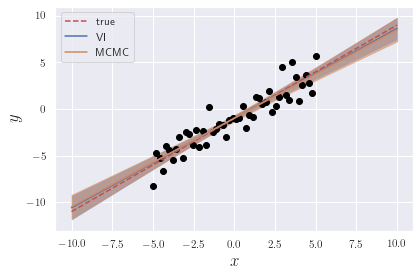

In [10]:
x_pred = np.linspace(-10, 10, 1000)

y_true_pred = model(x_pred, weights)

y_pred_mcmc_mean, y_pred_mcmc_std = mcmc.posterior_pred(x_pred)
y_pred_vi_mean, y_pred_vi_std = vi.posterior_pred(x_pred)

plt.plot(x_pred, y_true_pred, color='r', linestyle='--', label='true')
plt.plot(x_pred, y_pred_vi_mean, label='VI')
plt.fill_between(x_pred, y_pred_vi_mean + 2 * y_pred_vi_std, y_pred_vi_mean - 2 * y_pred_vi_std, alpha=0.5)
plt.plot(x_pred, y_pred_mcmc_mean, label='MCMC', color='#D1895C')
plt.fill_between(x_pred, y_pred_mcmc_mean + 2 * y_pred_mcmc_std, y_pred_mcmc_mean - 2 * y_pred_mcmc_std, color='#D1895C', alpha=0.5)
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.xlabel(r'$x$', fontsize=17)
plt.ylabel(r'$y$', fontsize=17)
plt.tight_layout()
plt.savefig('reg_mcmc_vi.pdf', bbox_inches='tight')
plt.show()

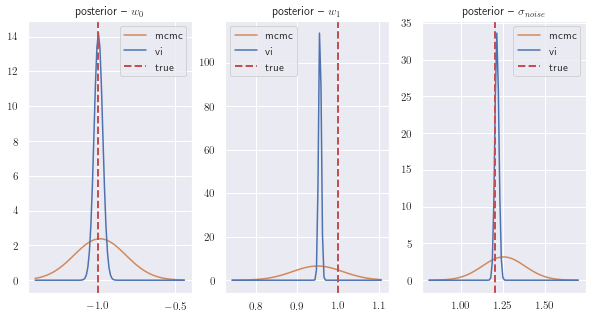

In [12]:
fig, axs = plt.subplots(1, mcmc.chain.shape[1], figsize=(10,5))
for i, ax in enumerate(axs):
    # mcmc
    samples = mcmc.chain[mcmc.burnin_iter-1:,i]
    x_w_viz = np.linspace(samples.min(), samples.max(), 100)
    
    mu_mcmc, std_mcmc = stats.norm.fit(samples)
    
    if i != len(axs)-1:
        # mcmc
        ax.plot(x_w_viz, stats.norm.pdf(x_w_viz, mu_mcmc, std_mcmc), label='mcmc', color='#D1895C')
        # vi
        ax.plot(x_w_viz, stats.norm.pdf(x_w_viz, vi.mN[i], vi.SN[i,i]), label='vi')
        ax.axvline(weights[i], color='r', linestyle='--', linewidth=2, label='true')
        ax.title.set_text(r'posterior -- $w_%d$' % i)
    else:
        vi_std_mean = np.sqrt(vi.x_var.mean())
        vi_std_std = np.sqrt(vi.x_var).std()
        new_x = np.linspace(mu_mcmc-3.5*std_mcmc, mu_mcmc+3.5*std_mcmc, 100)
        # mcmc
        ax.plot(new_x, stats.norm.pdf(new_x, mu_mcmc, std_mcmc), label='mcmc', color='#D1895C')
        # vi
        ax.plot(new_x, stats.norm.pdf(new_x, vi_std_mean, vi_std_std), label='vi')

        ax.axvline(std_noise, color='r', linestyle='--', linewidth=2, label='true')
        ax.title.set_text(r'posterior -- $\sigma_{noise}$')
    ax.legend()
plt.show()

## Appendix

### (Log) Gamma distribution

$$
\begin{aligned}
\textrm{Gam}(x|a,b) &= \frac{1}{\Gamma (a)} b^{a} x^{a-1} e^{-bx} \\
&= \frac{1}{(a-1)!} b^{a} x^{a-1} e^{-bx} \\
\log \textrm{Gam}(x|a,b) &= \underbrace{-\log\left((a-1)!\right) + a\log b}_{\textrm{const. w.r.t. }x} + (a-1)\log x - bx
\end{aligned}
$$

### Code for Drawing Confidence Ellipse

From official matplotlib <a href="https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html">documentation</a>.

In [5]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

#def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', edgecolor='black', **kwargs):
def confidence_ellipse(mu, cov, ax, n_std=3.0, facecolor='none', edgecolor='black', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    From: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    #if x.size != y.size:
    #    raise ValueError("x and y must be the same size")

    #cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, edgecolor=edgecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(mu[0])

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(mu[1])

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)